# Least Square Regression on Swedish Auto Insurance

The swedish auto insurance dataset contains:
- X = number of claims
- Y = total payment for all the claims in thousands of Swedish Kronor for geographical zones in Sweden


In [1]:
import os
import sys
import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Reading Excel file with Pandas

In [2]:
data_path = os.path.join('data', 'slr06.xls')
df = pd.read_excel(data_path, encoding_override="cp1252")
df.head()

*** No CODEPAGE record, no encoding_override: will use 'ascii'


,X,Y
0,108,392.5
1,19,46.2
2,13,15.7
3,124,422.2
4,40,119.4


### Data Visualization Using Seaborn

Two outliers are present between 100 and 125 number of claims.<br/>
We will keep them in the set of our experiments.

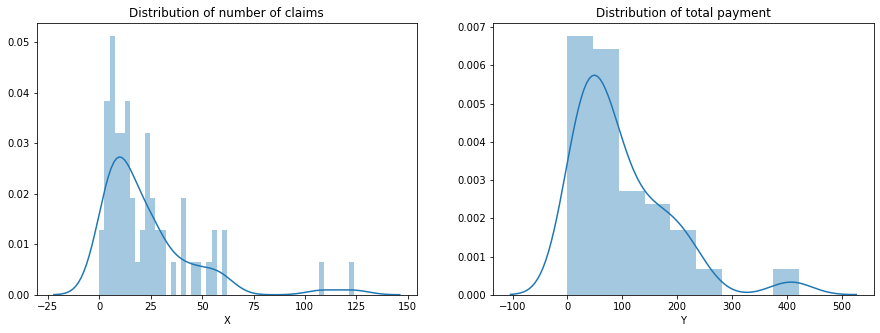

In [3]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
ax1.set_title('Distribution of number of claims')
ax2.set_title('Distribution of total payment')

sns.distplot(df.X, bins=50, hist=True, ax=ax1)
sns.distplot(df.Y, ax=ax2)

The mean of the number of claims is 22.9 and the mean total payment is 98.<br/>
The standard deviation of the number of claims is lower than the one of total payment.<br/>
In other words, the total payment is usually farther away from its mean than the number of claims.<br/>

In [4]:
df.describe().iloc[:3, :]

,X,Y
count,63.000000,63.000000
mean,22.904762,98.187302
std,23.351946,87.327553


The correlation heatmap and the plot above highlight that the number of claims and total payment are highly linearly correlated.

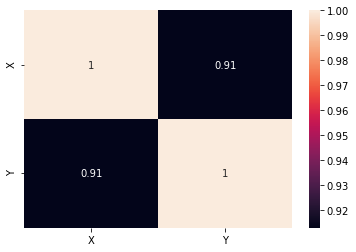

In [5]:
sns.heatmap(df.corr(), annot=True)

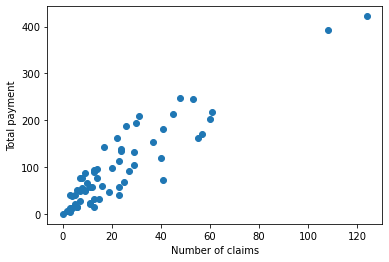

In [6]:
plt.xlabel('Number of claims')
plt.ylabel('Total payment')
plt.scatter(df['X'], df['Y'])

### Training Least Square Regressor

Convert the data to pytorch and separate the data into train & test.

In [7]:
data = df.to_numpy()
X = torch.from_numpy(data[:, 0]).float().unsqueeze(1)
Y = torch.from_numpy(data[:, 1]).float().unsqueeze(1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=50)

Training a least square regressor on one dimension using the above formula:<br/>
$y = b_0 + b_1x$ <br/>
$b_1 = \frac{\text{Cov}(x, y)}{Var(x)} = \frac{\sum_i{(x_i - \mathbb{E}[x]) * (y_i - \mathbb{E}[y])}}{\sum_i{(x_i - \mathbb{E}[x])^2}}$<br/>
where the expectation $\mathbb{E}[x]$ of a vector of random variables is its mean.

In [8]:
def linear_regression_1d(X, Y):
    X_m = X.mean(dim=0)
    Y_m = Y.mean(dim=0)
    
    # Centering X
    X_c = (X - X_m)
    
    # Compute covariance and variance
    covar = (X_c * (Y - Y_m)).sum(dim=0)
    var = X_c.pow(2).sum(dim=0)

    # Divide covariance by variance
    b_1 = covar / var
    
    # Get bias
    b_0 = Y_m - b_1 * X_m.sum(dim=0)
    return b_0, b_1

We are using Pytorch for the matrix calculus.

### Plot Regression Line 

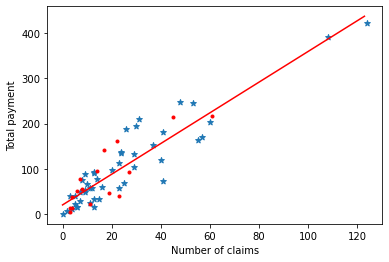

In [9]:
b_0, b_1 = linear_regression_1d(X_train, Y_train)
plt.scatter(X_train, Y_train, marker='*')
plt.scatter(X_test, Y_test, marker='.', color='red')

x = [int(elt) for elt in range(0, int(X.cpu().numpy().max()))]
y = b_0.numpy() + b_1.numpy() * x
plt.plot(x, y, color='red')

ax = plt.gca()
ax.set_xlabel('Number of claims')
ax.set_ylabel('Total payment')
plt.show()

Because both the data and target are highly correlated, the regression line fits pretty well the data distribution.

### Compute Mean Square Error

In [10]:
pred_train = b_0 + b_1 * X_train
err_train = torch.abs(Y_train - pred_train)
mse_train = err_train.T.mm(err_train) / Y_train.shape[0]

pred_test = b_0 + b_1 * X_test
err_test = torch.abs(Y_test - pred_test)
mse_test = err_test.T.mm(err_test) / Y_test.shape[0]

print('Train MSE:\t', mse_train.item())
print('Test MSE:\t', mse_test.item())

Train MSE:	 1241.5714111328125
Test MSE:	 1279.6766357421875


The train and test MSE are close to each other.<br/>
This means that the model neither underfit or overfit.

### Conclusion
The more a client claims money to the insurance, the more money he will get.